In [ ]:
################## Install libraries ##################

In [1]:
!pip install transformers datasets tensorboard --upgrade --quiet

In [2]:
!pip install accelerate --upgrade --quiet

In [3]:
!pip install GPUtil --upgrade --quiet

In [ ]:
########### Import libraries ###########

In [2]:
import numpy as np
import pandas as pd
import boto3
import json
import os
from pandas import option_context
from typing import Union, Dict, List, Optional
import re
import logging
from tqdm import tqdm
import time
from datetime import datetime, timedelta
import torch

In [5]:
from datasets import Dataset, ClassLabel, DatasetDict
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
from huggingface_hub import HfFolder, notebook_login
import numpy as np
from datasets import load_metric
import sagemaker
from sagemaker.huggingface import HuggingFace
from sagemaker.pytorch import PyTorchModel

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [6]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [7]:
########### Sagemaker Session Validate roles ###########

In [8]:
import sagemaker
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")


2024-05-17 17:47:24,835 - INFO - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
2024-05-17 17:47:25,287 - INFO - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
2024-05-17 17:47:25,512 - INFO - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


sagemaker role arn: arn:aws:iam::730335220874:role/service-role/AmazonSageMaker-ExecutionRole-20240131T123268
sagemaker bucket: sagemaker-us-east-1-730335220874
sagemaker session region: us-east-1


In [9]:
####### Load data from local folder and process and fine tune model ######

In [10]:
def load_dataframe(folder_name: str, file_name: str) -> Optional[pd.DataFrame]:
    """
    Loads a DataFrame from a CSV file in the specified folder.

    Args:
        folder_name (str): The name of the folder containing the CSV file.
        file_name (str): The name of the CSV file to load.

    Returns:
        pd.DataFrame: The loaded DataFrame, or None if an error occurred.
    """
    try:
        # Define the file path
        file_path = os.path.join(folder_name, file_name)
        
        # Check if the file exists
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File '{file_path}' not found.")
        
        # Load the DataFrame from the CSV file
        df = pd.read_csv(file_path)
        logging.info(f"DataFrame loaded from {file_path}")
        
        return df
    except Exception as e:
        logging.error(f"An error occurred while loading the DataFrame: {e}")
        return None

# call function
# Assuming the file was saved with the current date appended
folder_name = 'training-data'
file_name = 'training_data.csv_2024-05-17.csv'

df= load_dataframe(folder_name, file_name)

if df is not None:
    from pandas import option_context
    with option_context('display.max_rows', None, 'display.max_colwidth', 200, 'display.max_columns', 80):
        display(df.head(1))
else:
    logging.error("The DataFrame could not be loaded.")

2024-05-17 17:47:25,870 - INFO - DataFrame loaded from training-data/training_data.csv_2024-05-17.csv


,text,label,encoded_label
0,"Lufthansa flies back to profit German airline Lufthansa has returned to profit in 2004 after posting huge losses in 2003. In a preliminary report, the airline announced net profits of 400m euros (...",business,0


In [11]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',300,'display.max_columns',80):
        display(df.head(5))

,text,label,encoded_label
0,"Lufthansa flies back to profit German airline Lufthansa has returned to profit in 2004 after posting huge losses in 2003. In a preliminary report, the airline announced net profits of 400m euros ($527.61m; £274.73m), compared with a loss of 984m euros in 2003. Operating profits were at 380m euro...",business,0
1,"Winn-Dixie files for bankruptcy US supermarket group Winn-Dixie has filed for bankruptcy protection after succumbing to stiff competition in a market dominated by Wal-Mart. Winn-Dixie, once among the most profitable of US grocers, said Chapter 11 protection would enable it to successfully restru...",business,0
2,"US economy still growing says Fed Most areas of the US saw their economy continue to expand in December and early January, the US Federal Reserve said in its latest Beige Book report. Of the 12 US regions it identifies for the study, 11 showed stronger economic growth, with only the Cleveland ar...",business,0
3,"Saab to build Cadillacs in Sweden General Motors, the world's largest car maker, has confirmed that it will build a new medium-sized Cadillac BLS at its loss-making Saab factory in Sweden. The car, unveiled at the Geneva motor show, is intended to compete in the medium-sized luxury car market. I...",business,0
4,"Bank voted 8-1 for no rate change The decision to keep interest rates on hold at 4.75% earlier this month was passed 8-1 by the Bank of England's rate-setting body, minutes have shown. One member of the Bank's Monetary Policy Committee (MPC) - Paul Tucker - voted to raise rates to 5%. The news s...",business,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915 entries, 0 to 914
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           915 non-null    object
 1   label          915 non-null    object
 2   encoded_label  915 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.6+ KB


In [13]:
##### Dataset & Pre-processing #####

In [14]:
def preprocess_dataset(df: pd.DataFrame) -> Dataset:
    """
    Preprocesses the dataset by converting the DataFrame to a Dataset object
    and applying necessary transformations.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        Dataset: The preprocessed dataset.
    """
    try:
        # Convert DataFrame to Dataset
        dataset = Dataset.from_pandas(df[["text", "encoded_label"]])
        
        # Map labels to ClassLabel
        class_names = ['business', 'entertainment', 'food', 'graphics', 'historical', 'medical',
                       'other','politics', 'space', 'sport', 'technologie']
        class_feature = ClassLabel(names=class_names)
        dataset = dataset.cast_column("encoded_label", class_feature)
        
        # Rename target column to labels
        dataset = dataset.rename_column("encoded_label", "labels")
        
        # Split the dataset into train, validation, and test sets
        dataset = dataset.train_test_split(test_size=0.2, seed=42)
        train_val_dataset = dataset["train"].train_test_split(test_size=0.1, seed=42)
        dataset = DatasetDict({
            "train": train_val_dataset["train"],
            "validation": train_val_dataset["test"],
            "test": dataset["test"]
        })
        
        logging.info("Dataset preprocessed and split successfully")
        return dataset
    except Exception as e:
        logging.error(f"An error occurred during dataset preprocessing: {e}")
        raise

# Preprocess the dataset
dataset = preprocess_dataset(df)

Casting the dataset:   0%|          | 0/915 [00:00<?, ? examples/s]

2024-05-17 18:01:15,781 - INFO - Dataset preprocessed and split successfully


In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 658
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 74
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 183
    })
})

In [16]:
dataset["train"][0]

{'text': 'Comic Morris returns with sitcom Comedian Chris Morris, who created controversial TV show Brass Eye, is to return to screens with a new sitcom about a spoof London media worker. Morris will direct and co-write Nathan Barley - a character from cult website TV Go Home - for Channel 4. It is a send-up of the stereotypical "cool" metropolitan media scene, with Nicholas Burns in the title role. A Brass Eye satire of the media handling of paedophilia sparked 2,500 complaints in 2001. Nathan Barley will be "a character-driven comedy", according to Charlie Brooker, who created TV Go Home in 1999 and has co-written the series. Barley is described as a "webmaster, guerrilla film-maker, screenwriter, DJ and in his own words, a \'self-facilitating media node". The story will also feature Dan Ashcroft, a style magazine columnist, and his sister Claire, a film-maker who hates the "cool" scene. As well as Brass Eye, Morris was behind another news show satire, The Day Today, and dark sketch 

In [17]:
# Tokenize the dataset

In [18]:
model_id = "distilbert-base-uncased"

# name for our repository on the hub
model_name = model_id.split("/")[-1] if "/" in model_id else model_id
repo_name = f"{model_name}"

In [19]:
# Load the tokenizer
model_id = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [20]:
def tokenize_dataset(dataset: DatasetDict, tokenizer: AutoTokenizer) -> DatasetDict:
    """
    Tokenizes the dataset using the specified tokenizer.

    Args:
        dataset (DatasetDict): The input dataset.
        tokenizer (AutoTokenizer): The tokenizer to use for tokenization.

    Returns:
        DatasetDict: The tokenized dataset.
    """
    try:
        def tokenize(examples):
            return tokenizer(examples["text"], truncation=True, max_length=512)
        
        tokenized_dataset = dataset.map(tokenize, batched=True, remove_columns=["text"])
        logging.info("Dataset tokenized successfully")
        return tokenized_dataset
    except Exception as e:
        logging.error(f"An error occurred during dataset tokenization: {e}")
        raise
        
# Tokenize the dataset
tokenized_dataset = tokenize_dataset(dataset, tokenizer)

Map:   0%|          | 0/658 [00:00<?, ? examples/s]

Map:   0%|          | 0/74 [00:00<?, ? examples/s]

Map:   0%|          | 0/183 [00:00<?, ? examples/s]

2024-05-17 18:01:23,944 - INFO - Dataset tokenized successfully


In [21]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 658
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 74
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 183
    })
})

In [22]:
tokenized_dataset["train"][0]

{'labels': 1,
 'input_ids': [101,
  5021,
  6384,
  5651,
  2007,
  13130,
  9971,
  3782,
  6384,
  1010,
  2040,
  2580,
  6801,
  2694,
  2265,
  8782,
  3239,
  1010,
  2003,
  2000,
  2709,
  2000,
  12117,
  2007,
  1037,
  2047,
  13130,
  2055,
  1037,
  11867,
  21511,
  2414,
  2865,
  7309,
  1012,
  6384,
  2097,
  3622,
  1998,
  2522,
  1011,
  4339,
  7150,
  21569,
  1011,
  1037,
  2839,
  2013,
  8754,
  4037,
  2694,
  2175,
  2188,
  1011,
  2005,
  3149,
  1018,
  1012,
  2009,
  2003,
  1037,
  4604,
  1011,
  2039,
  1997,
  1996,
  12991,
  27086,
  1000,
  4658,
  1000,
  4956,
  2865,
  3496,
  1010,
  2007,
  6141,
  7641,
  1999,
  1996,
  2516,
  2535,
  1012,
  1037,
  8782,
  3239,
  18312,
  1997,
  1996,
  2865,
  8304,
  1997,
  6643,
  26010,
  21850,
  6632,
  13977,
  1016,
  1010,
  3156,
  10821,
  1999,
  2541,
  1012,
  7150,
  21569,
  2097,
  2022,
  1000,
  1037,
  2839,
  1011,
  5533,
  4038,
  1000,
  1010,
  2429,
  2000,
  4918,
  11535,

In [23]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=3):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    
    # Convert input_ids and attention_mask to strings for better readability
    df["input_ids"] = df["input_ids"].apply(lambda x: " ".join(map(str, x)))
    df["attention_mask"] = df["attention_mask"].apply(lambda x: " ".join(map(str, x)))
    
    display(HTML(df.to_html(index=False)))

show_random_elements(tokenized_dataset["train"])
    

labels,input_ids,attention_mask
food,101 1015 1048 2290 4086 2417 11565 1015 2452 22126 24881 7975 1008 1015 7251 24667 2078 23605 3514 1015 2452 12984 3180 5785 1015 18856 21818 20548 1011 1011 8117 11788 1015 1013 1016 2452 10424 2480 2078 2394 26072 1011 1011 22794 15557 1015 5572 13102 7828 8117 11788 4840 14580 3217 4140 8288 1011 1011 7854 1015 1013 1016 2452 22126 24881 25659 2015 1015 7251 24667 2078 4606 1015 1015 1013 1016 1056 25176 12901 1015 1013 1018 2452 4857 2135 15920 2665 24444 1015 1013 1022 5572 13102 7828 5474 1008 1015 2452 22126 24881 1010 12984 7975 7388 1006 19937 2077 8434 1007 3013 1037 1015 1013 1016 1000 4317 14704 2013 1996 2217 1997 2169 11565 1010 24501 25164 25609 1025 6366 8079 1012 2173 23582 1999 16018 2300 1010 26077 1019 2781 1012 12475 1010 2275 4998 1012 5435 1037 2312 8066 3388 2030 24185 2243 2007 14089 1025 5587 23605 3514 1010 1998 2173 2058 19960 3684 2127 2980 1012 5587 20548 1998 14580 3217 4140 1025 16130 14744 2382 3823 1012 5587 25659 2015 1998 2665 24444 1025 16130 14744 1016 2781 2062 1012 6366 2013 3684 1012 5587 7975 1998 3588 12760 1010 18385 2092 1012 15642 1017 1013 1018 2452 8150 2046 2169 9235 11565 1012 2327 2007 9235 11565 25609 1012 13621 23582 1010 3013 2217 2039 1010 1999 1037 2184 2595 2575 2595 2475 1000 21522 9841 1012 3104 1998 8670 3489 8698 2139 2290 1042 2005 2382 2781 2030 2127 12246 9685 1012 2566 3529 1024 20304 10250 18909 1010 2385 1012 1018 1043 5250 1010 1020 1012 1021 1043 6638 1010 2423 1012 1021 2482 5092 10536 7265 4570 5818 1043 16480 4244 27833 1010 1017 1012 1015 11460 3707 1010 4029 2575 11460 13365 1010 4261 11460 13853 1012 4991 2011 3461 8663 2615 2310 2869 1012 1015 1012 4002 102,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
technologie,101 8543 1997 2034 6207 6097 8289 15333 2546 20710 4939 1010 2132 1997 1996 2136 2369 1996 2034 22228 3274 1010 2038 2351 1012 2720 20710 4939 2001 2028 1997 1996 2034 5126 2012 6207 1998 2081 2116 1997 1996 2640 6567 2008 2081 1996 6097 2061 8200 2043 2009 2001 2034 2207 1012 2002 2419 1996 2136 2008 2787 2000 2224 1037 20477 8278 1998 8000 2008 2292 2111 22149 2105 1996 3274 2011 7302 1998 22042 1012 1996 3118 2713 1997 1996 6097 7686 2720 20710 4939 1005 1055 6772 2008 2204 2640 2323 2191 7588 3733 2000 2224 1012 2720 20710 4939 2587 6207 1999 3301 2004 7904 2193 2861 1010 3322 2000 2599 1996 2194 1005 1055 5523 2533 1012 2174 1010 1999 3245 2002 2001 2404 1999 3715 1997 1037 2235 2136 2000 2640 1037 3274 2008 2973 2039 2000 2010 2801 1997 1037 3698 2008 2001 10036 1010 6461 2012 10390 2738 2084 3274 8390 1998 2001 2200 3733 2000 2224 1012 1996 2765 2001 1996 3118 22228 2008 2106 2185 2007 1996 2059 2691 3793 1011 2241 8278 1999 7927 1997 2028 2241 2105 8389 2008 15881 1037 7484 15363 1998 2109 19622 2015 1998 5491 1012 5198 22149 2094 2105 1996 3698 2478 1037 8000 1998 2011 7302 1010 22042 1998 11920 1012 2348 2085 1999 2691 2224 1999 2471 2035 7588 1010 2122 4725 2020 13280 2043 2034 2109 1999 1996 22228 1012 1996 26458 2001 2764 2011 1060 10624 2595 27985 1010 1998 2109 1999 2049 2732 3698 1012 2021 1996 9920 1997 1996 8278 2106 2025 5621 4088 2127 1996 4145 2001 2764 2005 2224 2011 6207 1999 2049 13280 7059 3274 1012 1000 2010 2535 2006 1996 22228 2001 1996 1999 29050 4263 1997 1996 2622 1010 2061 2009 2876 1005 1056 2022 2182 2065 2009 4694 1005 1056 2005 2032 1010 1000 2056 5557 2014 5753 8151 1010 2019 2220 22228 2136

In [24]:
show_random_elements(tokenized_dataset["test"])

labels,input_ids,attention_mask
sport,101 21259 18989 2954 2114 5850 1996 21259 1011 6482 1005 2088 8677 2303 1011 2038 2777 3424 1011 23799 4584 1010 7850 1998 7576 2000 2522 1011 2030 18979 2618 1996 2954 2114 5850 1999 4368 1012 2048 4708 2749 2031 2042 2275 2039 2000 11628 23799 1998 14266 3314 1012 2009 2001 2036 3530 2008 1037 4746 2000 1000 2139 1011 2026 16643 12031 1000 1996 3277 2000 7576 1010 1996 2270 1998 1996 2865 2001 1037 9470 1012 1000 2498 2001 2787 2000 2689 2477 1011 2009 2001 2062 2000 2031 1037 7057 1997 1996 22859 4352 2068 2000 4671 3209 1010 1000 2056 2019 21259 14056 1012 1000 2893 3071 2362 2435 2149 1037 2843 1997 2833 2005 2245 1012 1000 2055 3438 2111 3230 4465 1005 1055 3116 1999 14497 1010 2164 21259 2708 16983 3170 22939 3600 1998 15408 2078 8258 12784 5406 2015 1010 2085 1037 2266 1997 1996 7576 1005 3222 1012 1000 1045 2572 2200 3407 2000 2156 2017 2035 1010 2372 1997 1996 6482 2155 1010 6869 13567 2000 1996 21259 2655 2000 4133 2362 1998 6848 2054 2062 2057 2064 2079 1999 1996 2954 2114 23799 1010 1000 2056 22939 3600 1012 1000 2057 2024 1996 2877 4657 1999 2023 2492 1998 2009 2003 2256 4611 2000 2562 2256 4368 4550 1012 1000 1996 2048 4708 2749 2097 3189 2067 2000 1996 21259 2473 1010 2012 2049 2258 3116 1999 12577 1012 102,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
other,101 1999 2019 18988 4653 1997 2451 4382 1010 3901 1997 1996 5780 2237 1997 11615 13312 2031 3390 1037 2312 1011 4094 4483 27686 6349 6461 2012 16487 1996 3019 5053 1997 2037 2334 12212 1998 2380 8653 1012 1996 2724 1010 4114 2011 1996 11615 13312 4483 2177 1010 6296 2058 3998 7314 2040 5935 2220 5095 2851 1010 6055 2007 11875 1010 8641 1010 1998 2019 4895 16535 4892 8426 2000 2191 1037 4489 1012 1996 6349 3139 2536 4573 1010 2164 1996 2759 13152 3509 1998 7222 7676 2380 1010 2029 2031 2464 2019 3623 1999 19070 1998 10796 2058 1996 2627 2095 1012 7314 15844 2013 2402 2336 2000 9750 3901 1010 2035 2551 2362 2000 8145 11669 1010 6366 17760 4475 1010 1998 5333 7073 2055 1996 5197 1997 4483 17946 9650 1012 2334 5661 5201 2000 1996 3947 2011 4346 6067 1010 25416 21898 8163 1010 1998 3361 2490 1010 14313 1996 2451 1005 1055 7268 10663 2000 11147 4483 3314 2132 1011 2006 1012 1996 27686 5531 2007 1037 2235 5103 2073 18829 15583 6818 1998 11548 1996 4254 1997 2037 4073 1024 2195 6197 1997 11669 2020 5067 1998 7919 21866 1997 1010 1998 3488 2020 2081 2005 2925 4483 3450 1012 2023 6349 2025 2069 17935 3775 10451 1996 2334 2752 2021 2036 13949 2451 9547 1998 11548 1996 2373 1997 7268 2895 1999 12786 4483 7860 1012 3901 2187 1996 2724 3110 1037 9100 3168 1997 6620 1999 2037 2451 1998 1037 8426 2000 5719 2122 4073 2802 1996 2095 1012 102,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
entertainment,101 1996 6443 23348 2015 2754 2982 1996 6443 2038 7854 2984 3769 27915 1999 1996 2645 1997 1996 27858 2225 2203 20103 2012 1996 14439 2982 1012 1996 6443 2180 2093 11580 2012 1996 2866 1005 1055 2087 8919 3296 3004 2982 1010 2096 2984 3769 27915 2180 2048 1012 11463 8379 1005 2718 2265 10911 2098 1999 1996 2645 2005 2190 2047 3315 1010 2

In [25]:
# Create label2id and id2label dicts
labels = tokenized_dataset["train"].features["labels"].names
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [26]:
label2id

{'business': '0',
 'entertainment': '1',
 'food': '2',
 'graphics': '3',
 'historical': '4',
 'medical': '5',
 'other': '6',
 'politics': '7',
 'space': '8',
 'sport': '9',
 'technologie': '10'}

In [27]:
##### Now we Fine-tune  the model using PyTorch and Trainer  Trellis dataset looks good ##### 

In [28]:
### Hyperparameter Definition, Model Loading

In [29]:
# Define training arguments
tracing_steps = 100
training_args = TrainingArguments(
    output_dir=repo_name,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=f"{repo_name}/logs",
    logging_strategy="steps",
    logging_steps=tracing_steps,
    evaluation_strategy="steps",
    eval_steps=tracing_steps,
    save_strategy="steps",
    save_steps=tracing_steps,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="tensorboard",
    push_to_hub=False
)


# define data_collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# define model
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=num_labels, 
    id2label=id2label,
    label2id=label2id,
)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
model_id

'distilbert-base-uncased'

In [31]:
num_labels

11

In [32]:
#### Evaluation metric

from datasets import load_metric
import numpy as np

# define metrics and metrics function
f1_metric = load_metric("f1", trust_remote_code=True)
accuracy_metric = load_metric( "accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="micro")
    return {
        "accuracy": acc["accuracy"],
        "f1": f1["f1"],
    }


#### This function will be used during the training process to compute the accuracy &
### f1 of our Trellis documentation classification model.

/tmp/ipykernel_60787/531426223.py:7: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  f1_metric = load_metric("f1", trust_remote_code=True)


In [33]:
#### Early Stopping Callback - Trainer Callbacks: - Prevents Overfitting, Improves Generalization

In [35]:
from transformers.trainer_callback import EarlyStoppingCallback

callbacks=[]

callbacks.append(EarlyStoppingCallback(early_stopping_patience=5))

### The training process will stop if the validation metric (accuracy in this case) does not improve for 5 consecutive
### evaluation steps.

In [36]:
### clear CUDA cache

In [37]:
from GPUtil import showUtilization as gpu_usage
from numba import cuda

In [40]:
def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

if torch.cuda.is_available():
    free_gpu_cache()

2024-05-17 18:02:18,071 - INFO - init
2024-05-17 18:02:18,139 - INFO - reset context of device 0


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  7% |  1% |


In [ ]:
#### Training
### Start training with calling model.fit

In [41]:
# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=callbacks,
)


In [42]:
# Train the Trellis document classification model
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
100,2.235500,1.777172,0.864865,0.864865
200,0.989100,0.324713,0.972973,0.972973


TrainOutput(global_step=210, training_loss=1.550470285188584, metrics={'train_runtime': 52.684, 'train_samples_per_second': 62.448, 'train_steps_per_second': 3.986, 'total_flos': 435496435720752.0, 'train_loss': 1.550470285188584, 'epoch': 5.0})

In [43]:
print("Path at terminal when executing this file")
print(os.getcwd() + "\n")

Path at terminal when executing this file
/home/ec2-user/SageMaker/Trellis



In [44]:
##### save model as satensors as well

In [46]:
trainer.save_model()

In [47]:
##### evaluate best model 

In [48]:
tokenized_dataset["test"][0]

{'labels': 3,
 'input_ids': [101,
  2941,
  1045,
  2572,
  2667,
  2000,
  4339,
  2242,
  2066,
  2023,
  2021,
  1045,
  8087,
  2070,
  3471,
  1010,
  5921,
  2068,
  1024,
  1011,
  5059,
  1037,
  7605,
  7318,
  15643,
  3193,
  1997,
  1037,
  17718,
  7277,
  1013,
  24209,
  8445,
  2594,
  5942,
  2008,
  2017,
  2031,
  1996,
  13216,
  8522,
  1997,
  1996,
  17718,
  7277,
  1013,
  24209,
  8445,
  2594,
  1006,
  1060,
  1010,
  1061,
  1010,
  1062,
  4972,
  1997,
  2070,
  11709,
  1007,
  1012,
  2129,
  2000,
  10463,
  1996,
  24655,
  8522,
  2109,
  2011,
  13433,
  2615,
  2000,
  2019,
  13216,
  2028,
  1029,
  2003,
  2009,
  8045,
  2135,
  2467,
  2825,
  1029,
  1045,
  2123,
  1005,
  1056,
  2031,
  2438,
  8785,
  2000,
  2424,
  2041,
  2011,
  2870,
  1010,
  2038,
  10334,
  2657,
  2055,
  6179,
  2808,
  2006,
  1996,
  3395,
  1029,
  102],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1

In [49]:
trainer.evaluate(eval_dataset=tokenized_dataset["test"])

{'eval_loss': 0.37023454904556274,
 'eval_accuracy': 0.9781420765027322,
 'eval_f1': 0.9781420765027322,
 'eval_runtime': 0.9067,
 'eval_samples_per_second': 201.83,
 'eval_steps_per_second': 13.235,
 'epoch': 5.0}

In [ ]:
##### create quick visualization for losses  #####

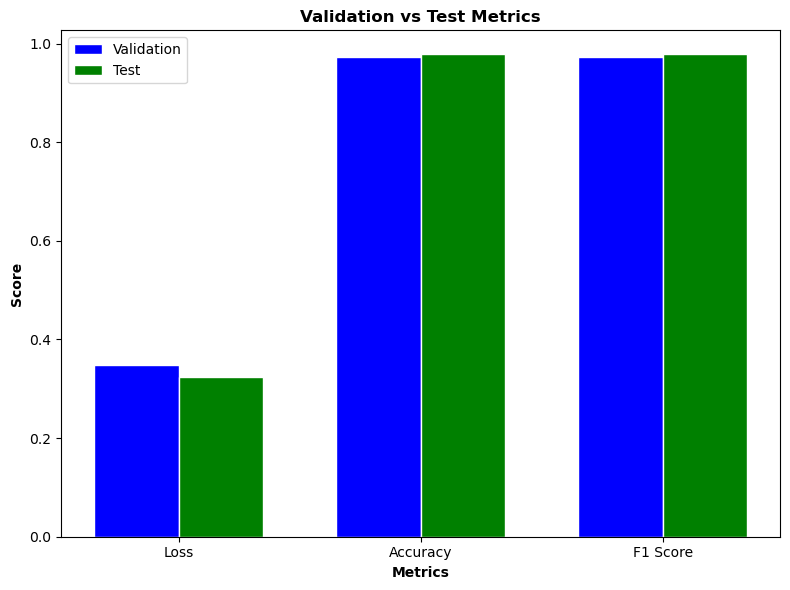

In [3]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Validation results
val_loss = 0.3476
val_accuracy = 0.9729
val_f1 = 0.9729

# Test results
test_loss = 0.3247
test_accuracy = 0.9781
test_f1 = 0.9781

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(3)
r2 = [x + bar_width for x in r1]

# Create the bars for validation and test
plt.bar(r1, [val_loss, val_accuracy, val_f1], color='b', width=bar_width, edgecolor='white', label='Validation')
plt.bar(r2, [test_loss, test_accuracy, test_f1], color='g', width=bar_width, edgecolor='white', label='Test')

# Add labels and title
plt.xlabel('Metrics', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.title('Validation vs Test Metrics', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(3)], ['Loss', 'Accuracy', 'F1 Score'])

# Add legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
Step	Training Loss	Validation Loss	Accuracy	F1
100	2.235500	1.777172	0.864865	0.864865
200	0.989100	0.324713	0.972973	0.972973

In [ ]:
# ### Specific Results Interpretation
# - **Step 100**:
#   - **Training Loss = 2.235500**: Initially, the model had a relatively high loss, indicating it was not performing well at the beginning.
#   - **Validation Loss = 1.777172**: The validation loss is slightly lower than the training loss, which is unusual but might occur due to various factors like model regularization techniques affecting training differently than validation.
#   - **Accuracy = 0.864865**: About 71.23% of the validation set predictions were correct.
#   - **F1 = 0.864865**: The F1 score is also 0.7123, indicating moderate precision and recall.

# - **Step 200**:
#   - **Training Loss = 0.989100**: The training loss has decreased significantly, indicating that the model has learned and improved from the training data.
#   - **Validation Loss = 0.324713**: A substantial decrease in validation loss, suggesting improved generalization and performance on unseen data.
#   - **Accuracy = 0.972973**: A high accuracy of 97.26% on the validation set, showing excellent performance.
#   - **F1 = 0.972973**: Similarly, a high F1 score indicates very good precision and recall.


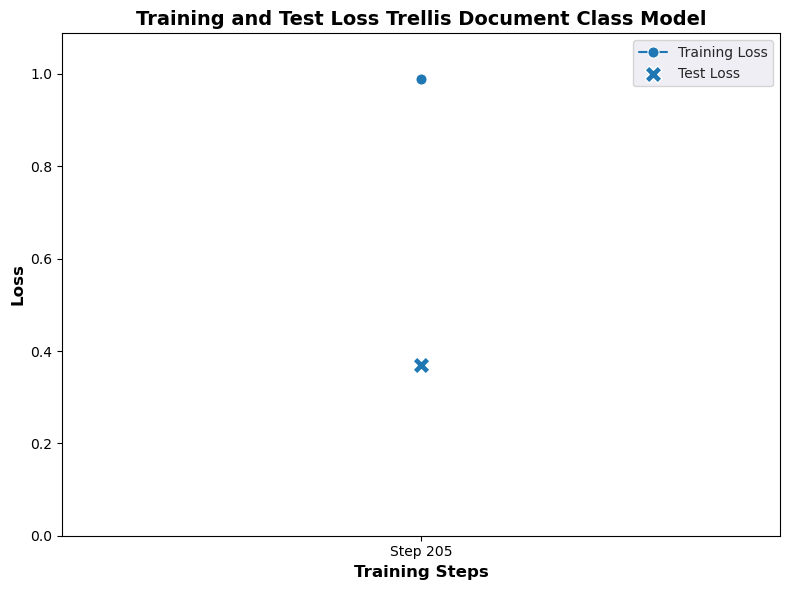

In [4]:
import seaborn as sns

# Training loss
train_loss = [0.9891]

# Test loss
test_loss = [0.37023]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Set the style and color palette
sns.set_style("darkgrid")
sns.set_palette("bright")

# Plot the training loss
sns.lineplot(x=[205], y=train_loss, label='Training Loss', marker='o', markersize=8)

# Plot the test loss
sns.scatterplot(x=[205], y=test_loss, label='Test Loss', marker='X', s=150)

# Add labels and title
plt.xlabel('Training Steps', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('Training and Test Loss Trellis Document Class Model', fontsize=14, fontweight='bold')

# Set the x-tick labels
plt.xticks([205], ['Step 205'], fontsize=10)

# Set the y-axis limits
plt.ylim(0, max(train_loss + test_loss) * 1.1)

# Add a legend
plt.legend(loc='upper right', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()

In [52]:
########  test model predictions one sample  trellis model #####

In [2]:
input_news = """
Grilled Shrimp Tacos with Avocado-Corn Salsa
instruction 
Remove the corn kernels from the cobs: Place a large container on a damp towel. Fold a paper towel into fourths and place it inside the container. Stand 1 ear of corn on the paper towel, using the stem as a handle. Using a paring knife, slice downward, letting the kernels fall into the container. Rotate the cob and continue until all the kernels have been removed; discard the cob. Repeat with the remaining corn. Discard the paper towel.
Add the scallions, tomatoes, measured lime juice, cilantro, serrano, and measured salt and stir to combine.
Halve and pit the avocados. Using a paring knife, score the flesh of the avocado halves in a 1/4-inch-wide crosshatch pattern (be careful not to cut through the skin). Using a spoon, scoop the avocado pieces into the corn mixture and gently fold to combine.
Taste and add more lime juice or salt as needed; set aside.
For the tacos:
Heat an outdoor grill to high (about 450°F to 550°F). Meanwhile, assemble the shrimp.
Whisk the lime juice, oil, chipotle powder, salt, and cumin together in a large bowl. Add the shrimp and toss to combine.
Skewer each shrimp through the tail and head ends, leaving about 1/4 inch of space between each shrimp. Transfer the skewers to a baking sheet.
Place the skewers in a single layer on the grill without touching. Close the grill and cook until grill marks appear on the bottom, about 4 minutes. Flip the skewers, close the grill, and cook until the shrimp are just firm, about 1 minute more. Transfer the skewers to a clean baking sheet.
Remove and discard the skewers, transfer the shrimp to a cutting board, and coarsely chop. Place in a serving bowl.
Serve the shrimp with the tortillas and salsa.
""".strip()

In [3]:
import os
import logging
import re
from html import unescape
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import torch

logging.basicConfig(level=logging.INFO)

def load_model_and_tokenizer(model_dir: str):
    """
    Loads the fine-tuned model, tokenizer, and configuration from the specified directory.

    Args:
        model_dir (str): The directory containing the fine-tuned model.

    Returns:
        tuple: A tuple containing the loaded model, tokenizer, and label map.
    """
    try:
        model = AutoModelForSequenceClassification.from_pretrained(model_dir)
        tokenizer = AutoTokenizer.from_pretrained(model_dir)
        config = AutoConfig.from_pretrained(model_dir)
        label_map = {int(k): v for k, v in config.id2label.items()}
        logging.info(f"Model, tokenizer, and label map loaded successfully from {model_dir}")
        return model, tokenizer, label_map
    except Exception as e:
        logging.error(f"An error occurred while loading the model, tokenizer, and label map: {e}")
        raise

def clean_text_content_trellis(text_content: str) -> str:
    """
    Cleans text content of document text by performing several operations:
    - Normalizes line breaks to Unix-style.
    - Removes excessive whitespace within lines.
    - Strips HTML tags and decodes HTML entities.
    - Normalizes paragraph breaks to ensure readability.

    Args:
        text_content (str): The raw text content to be cleaned.

    Returns:
        str: The cleaned text content.
    """
    try:
        # Normalize line breaks to Unix-style
        text_content = re.sub(r'\r\n|\r', '\n', text_content)
        # Remove excessive whitespace within lines
        text_content = re.sub(r'\s+', ' ', text_content).strip()
        # Strip HTML tags and decode HTML entities
        text_content = re.sub(r'<[^>]+>', '', text_content, flags=re.DOTALL)
        text_content = unescape(text_content)
        # Normalize paragraph breaks to ensure readability
        text_content = re.sub(r'\n{3,}', '\n\n', text_content)
        return text_content
    except Exception as e:
        logging.error(f"An error occurred while cleaning the text content: {e}")
        return ""

def predict_category(model, tokenizer, input_text: str, label_map: dict):
    """
    Predicts the category of the input text using the fine-tuned model.

    Args:
        model: The loaded fine-tuned model.
        tokenizer: The loaded tokenizer.
        input_text (str): The input text to predict the category for.
        label_map (dict): A dictionary mapping label indices to category names.

    Returns:
        str: The predicted category of the input text.
    """
    try:
        # Clean the input text
        cleaned_text = clean_text_content_trellis(input_text)
        
        # Tokenize the cleaned text
        inputs = tokenizer(cleaned_text, return_tensors="pt", truncation=True, max_length=512)
        
        # Make the prediction
        with torch.no_grad():
            outputs = model(**inputs)
            predicted_label_id = outputs.logits.argmax().item()
        
        # Map the predicted label index to the corresponding category name
        predicted_category = label_map[predicted_label_id]
        
        logging.info(f"Predicted category: {predicted_category}")
        return predicted_category
    except Exception as e:
        logging.error(f"An error occurred while making the prediction: {e}")
        raise

# model folder
model_dir = "distilbert-base-uncased-finetuned-Trellis/"

# Load the model, tokenizer, and label map
model, tokenizer, label_map = load_model_and_tokenizer(model_dir)

# Make the prediction
predicted_category = predict_category(model, tokenizer, input_news, label_map)

print(f"Predicted category: {predicted_category}")

INFO:root:Model, tokenizer, and label map loaded successfully from distilbert-base-uncased-finetuned-Trellis/
INFO:root:Predicted category: food


Predicted category: food


In [4]:
# Make the prediction
other = """ """
predicted_category = predict_category(model, tokenizer, input_news, label_map)

print(f"Predicted category: {predicted_category}")

INFO:root:Predicted category: food


Predicted category: food
